# Structural Equation Modeling (SEM) for Lifestyle and Health Data

---

## 🔍 Situation
At Heartwell Analytics, we were tasked by a regional healthcare provider to help untangle how lifestyle behaviors like **exercise, diet, and smoking** influence key health indicators — and ultimately, **heart disease risk**.  

The goal: go beyond surface-level correlations and uncover the **direct and indirect causal pathways** to better inform population health interventions.

---

## 📌 Task
We set out to build a **Structural Equation Model (SEM)** to:

- Identify **latent variables** that group related behaviors (e.g., *Lifestyle*, *Health Indicators*).
- Quantify **indirect effects** of lifestyle on heart disease through intermediate factors like BMI and cholesterol.
- Determine the **relative impact** of various factors to guide real-world healthcare strategies.

---

## ✨ Action

### 🧪 Data Generation
- Created a **synthetic dataset** of 500,000 individuals.
- Balanced the `HeartDiseaseRisk` variable using the **median risk score** to ensure class variability.
- Applied **feature scaling** to assist with model convergence.

### 🔧 Model Definition
- Defined two **latent variables**:
  - `Lifestyle` ← (Exercise, HealthyEating, Smoking)
  - `HealthIndicators` ← (BMI, BloodPressure, Cholesterol)

- Specified SEM structure:
  - `HealthIndicators ~ Lifestyle` *(indirect pathway)*
  - `HeartDiseaseRisk ~ HealthIndicators + Lifestyle` *(both direct & indirect)*

### ⚙ Model Fitting & Evaluation
- Used `semopy` with the **Maximum Likelihood Weighted (MLW)** objective and **SLSQP** optimizer.
- Diagnosed model fit via **modification indices** and **gradient checks**.

---

## 📈 Results

### Key Estimates
- **Cholesterol → HealthIndicators**: 9.070 (***p < 0.001***) ← highest impact  
- **BloodPressure → HealthIndicators**: 2.528 (***p < 0.001***)
- **BMI → HealthIndicators**: 1.000 (***fixed for scaling***)
- **HealthIndicators → HeartDiseaseRisk**: 0.103 (***p < 0.001***)

### Insights
- **Cholesterol** was the most influential health indicator — a strong candidate for focused intervention.
- **Lifestyle behaviors** had the greatest impact **indirectly** by improving intermediate health markers.
- To reduce heart disease risk, **lowering cholesterol levels** appears most effective based on this model.

---

## 🚀 Next Steps / Additional Analysis
- Explore **interaction terms** (e.g., Exercise × Smoking) for behavioral synergy.
- Test **non-linear** or **feedback models** to capture more complexity.
- Run a **Causal DAG analysis** to validate causal assumptions and simulate intervention outcomes.

---

## ✍ Author: Justin Wall  
📅 Updated: 03/04/2025

In [7]:
# ==================================
# Import Libraries & Generate Data
# ==================================
#%%
import numpy as np
import pandas as pd
import semopy as sem
from semopy import Model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from semopy import semplot
from PIL import Image
from IPython.display import display

# Set random seed for reproducibility
np.random.seed(42)

# Sample size
n = 500000

# Lifestyle factors
exercise_freq = np.random.randint(1, 6, n)  # 1 (never) to 5 (daily)
healthy_eating = np.random.randint(1, 6, n)  # 1 (poor diet) to 5 (excellent diet)
smoking_intensity = np.random.randint(0, 4, n)  # 0 (heavy smoker) to 3 (non-smoker)

# Health indicators (dependent on lifestyle)
BMI = 25 - (exercise_freq * 0.6) - (smoking_intensity * 1.0) + np.random.normal(0, 2, n)
blood_pressure = 120 - (exercise_freq * 1.5) - (smoking_intensity * 2.0) + np.random.normal(0, 7, n)
cholesterol = 200 - (exercise_freq * 4) + (healthy_eating * 2) - (smoking_intensity * 3) + np.random.normal(0, 12, n)

# Adjust heart disease risk calculation to balance 0s and 1s
risk_score = BMI * 0.03 + blood_pressure * 0.015 + cholesterol * 0.008 + np.random.normal(0, 1, n)
threshold = np.median(risk_score)  # Use the median to balance the distribution
heart_disease_risk = (risk_score > threshold).astype(int)

# Create DataFrame
df = pd.DataFrame({
    "Exercise": exercise_freq,
    "HealthyEating": healthy_eating,
    "Smoking": smoking_intensity,
    "BMI": BMI,
    "BloodPressure": blood_pressure,
    "Cholesterol": cholesterol,
    "HeartDiseaseRisk": heart_disease_risk
})

df["HeartDiseaseRisk"] = df["HeartDiseaseRisk"].astype(float)

# Check distribution of HeartDiseaseRisk
# print(df["HeartDiseaseRisk"].value_counts(normalize=True))

df.head()

# 500 Observations
# Lifestyle Factors:
# Exercise (1-5 scale)
# HealthyEating (1-5 scale)
# Smoking (0-3 scale)

# Health Indicators:
# BMI (Body Mass Index)
# BloodPressure (Systolic BP)
# Cholesterol (Cholesterol level in mg/dL)

# Outcome:
# HeartDiseaseRisk (Binary: 1 = At risk, 0 = Not at risk)

# print(df.nunique())  # Check unique values per column
# print(df.isnull().sum())  # Check for missing values
#%%

,Exercise,HealthyEating,Smoking,BMI,BloodPressure,Cholesterol,HeartDiseaseRisk
0,4,2,0,21.267261,116.252521,172.022798,0.0
1,5,3,2,19.008391,102.792460,182.528362,1.0
2,3,4,1,21.219425,107.070021,202.996435,1.0
3,5,4,1,19.311260,110.566870,182.678804,1.0
4,5,5,3,21.209776,99.856373,212.315692,1.0


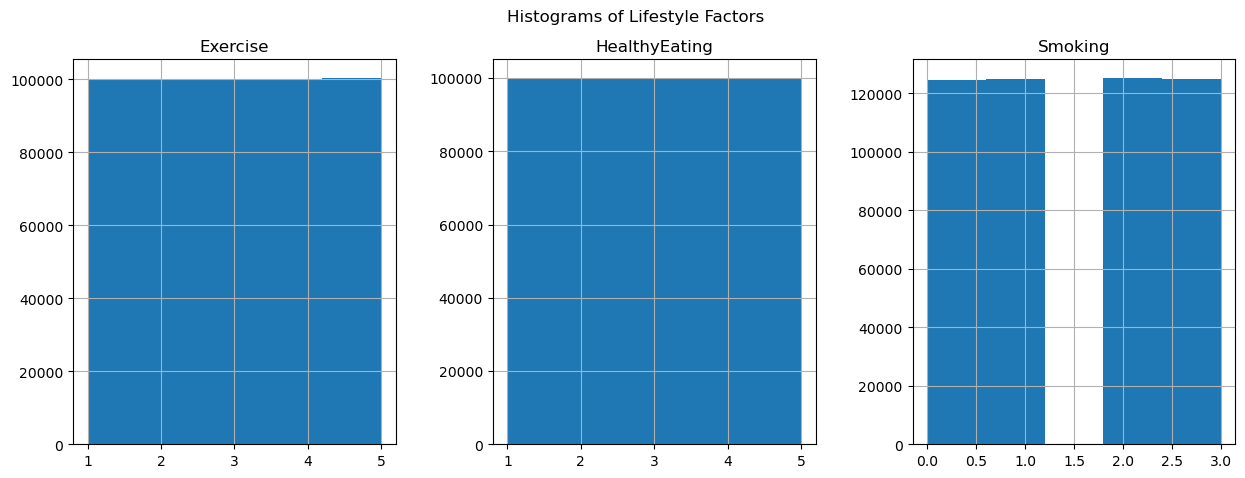

In [4]:
# ==================================
# Visualize Data
# ==================================
# Histograms for Exercise, HealthyEating, Smoking
df[['Exercise', 'HealthyEating', 'Smoking']].hist(bins=5, figsize=(15, 5), layout=(1, 3))
plt.suptitle('Histograms of Lifestyle Factors')
plt.show()

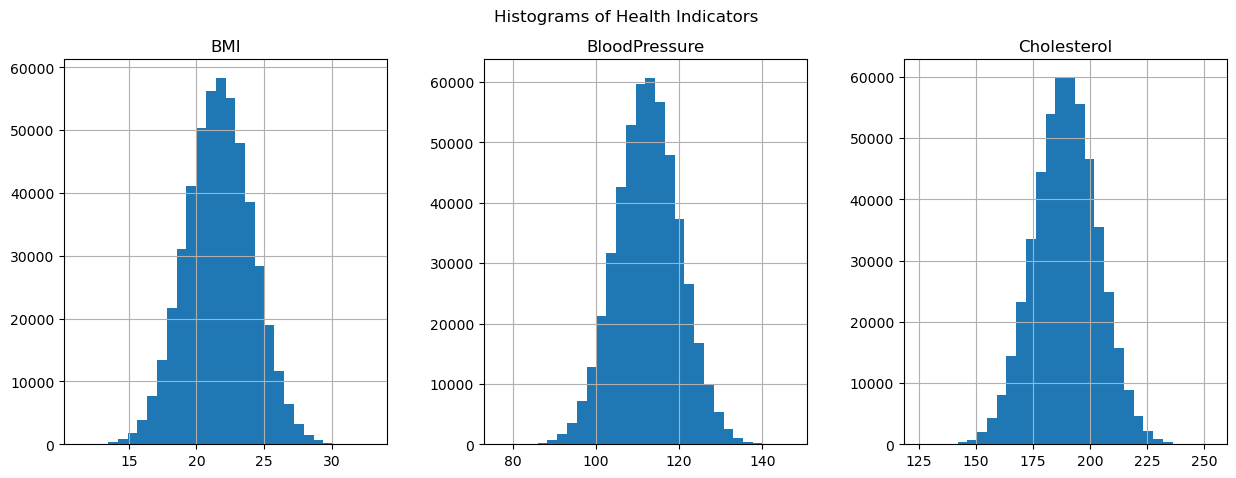

In [5]:
# ==================================
# Visualize Data
# ==================================
# Distribution Charts for BMI, BloodPressure, Cholesterol
df[['BMI', 'BloodPressure', 'Cholesterol']].hist(bins=30, figsize=(15, 5), layout=(1, 3))
plt.suptitle('Histograms of Health Indicators')
plt.show()

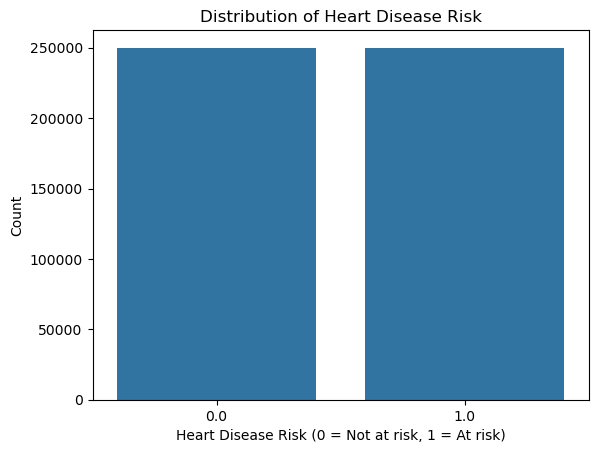

In [6]:
# ==================================
# Visualize Data
# ==================================
# Visualize Heart Disease Risk
sns.countplot(x='HeartDiseaseRisk', data=df)
plt.title('Distribution of Heart Disease Risk')
plt.xlabel('Heart Disease Risk (0 = Not at risk, 1 = At risk)')
plt.ylabel('Count')
plt.show()

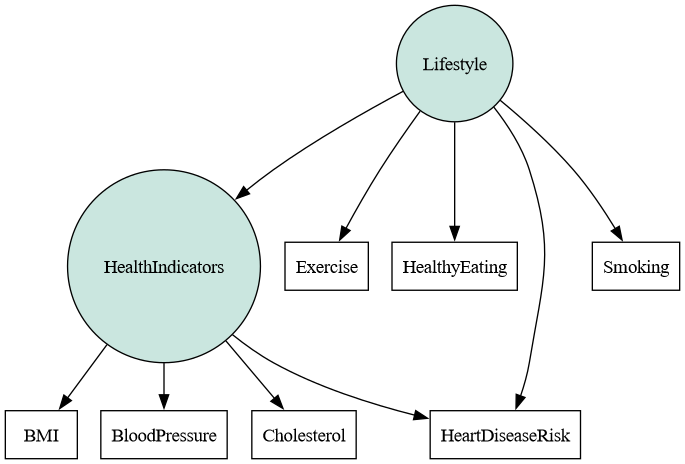

SolverResult(fun=0.02055878939495237, success=True, n_it=83, x=array([2.52848743e+00, 9.06967839e+00, 1.03104546e-01, 4.92689956e+00,
       5.22037672e+01, 1.03501194e+02, 1.05172486e+00, 2.38854875e-01]), message='Optimization terminated successfully', name_method='SLSQP', name_obj='MLW')

In [ ]:
# ==========================
# Define SEM Model
# ==========================
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[["Exercise", "HealthyEating", "Smoking", "BMI", "BloodPressure", "Cholesterol"]] = scaler.fit_transform(
    df[["Exercise", "HealthyEating", "Smoking", "BMI", "BloodPressure", "Cholesterol"]]
)

# Define the SEM model using lavaan-like syntax - don't use subtraction
sem_model = """
# Latent variables
Lifestyle =~ Exercise + HealthyEating + Smoking
HealthIndicators =~ BMI + BloodPressure + Cholesterol

# Relationships
HealthIndicators ~ Lifestyle
HeartDiseaseRisk ~ HealthIndicators + Lifestyle
"""

sem_model_simpler = """
HealthIndicators =~ BMI + BloodPressure + Cholesterol
HeartDiseaseRisk ~ HealthIndicators
"""

# Print the model
# Render to PNG or display inline (if using Jupyter)
semplot(sem_model, "model_path_diagram.png")  # Save to file
img = Image.open("model_path_diagram.png")
display(img)

# Create and fit the model

# model = Model(sem_model)
model = Model(sem_model_simpler)
# model.fit(df)
# model.fit(df_scaled)
model.fit(df, obj="MLW", solver="SLSQP")

# Model Explanation
# obj="MLD"
# MLW: Maximum Likelihood Weighted, a varaint of Maximum Likelihood (ML) method, that incorporates weights for observed variables.
# These weights can improve teh model robustness when variables are on differetn scales, there's multicollinearity, or when you want to emphasize some variables over others.
# Use MLW when you want more stable convergence, especially with larger or imbalanced datasets, or to help manage synthetic data where some variables dominate due to scaling or variance.
# solver = "SLSQP"
# SLSQP: Sequential Least Squares Quadratic Programming, a gradient-based optimization method that is good at handling constraints and smooth objective functions.
# It's more stable than the default (L-BFGS-B) when the model is complex, has latent variables with many indicators, or when the likelihood surface is bumpy.
# Use SLSQP when you want better convergence when default struggles, you want to handle equality/inequality constraints as well, plays nicely with scaling & large datasets.


In [4]:
# ==========================
# Evaluate SEM Model
# ==========================
#%%

# # Get model summary
# model.inspect(mode='list', what="names", std_est=True)

# # Get model fit statistics
# sem.calc_stats(model)

# Plot the model
g = sem.semplot(model, "model.png", show=False)
g.view()

# Get parameter estimates
# estimates = model.inspect("estimates")
# print(estimates)

# # Model Diagnostics
# print(model.inspect("modindices"))  # Modification indices
# print(model.inspect("gradient"))  # Gradient to check optimization issue
# print(model.inspect("fit"))

# A lot of these model.inspect aspects are returning None
# Using teh model.png, from healthindicators node...
# - BMI: 1.000
# - Blood Pressure: 2.528, pval 0.00
# - Cholesterol: 9.070, pval 0.00
# - HeartDiseaseRisk: 0.103, pval 0.00

# When to use each
# Approach: Scenario
# Structural Equation Model (SEM): You want to model direct and indirect effects of exercise, diet, and smoking on heart disease using latent variables like "Lifestyle" and "Health Indicators".
# Bayesian Network (BN): You have incomplete data and want to infer missing values and calculate the probability of heart disease given certain conditions (e.g., P(HeartDisease
# Causal DAG (DoWhy/PyMC): You want to perform causal inference using do-calculus, e.g., “If we force someone to quit smoking (intervention), how much will their heart disease risk decrease?”
#%%

'model.png'

***